In [23]:
from quantum_circuit import *
import numpy as np
import pandas as pd 

dbg = False

act_ratios_df = pd.read_csv('../act_ratios.csv', header=None) 
act_ratios = act_ratios_df[1].values 
genes_names = act_ratios_df[0].values
theta_in = np.diag(act_ratios)
print(theta_in)
a = encoder_layer(theta_in, debug = dbg)

psi_in = np.kron([1,0],[1,0])
psi_in = np.kron(psi_in, [1,0])
psi_in = np.kron(psi_in, [1,0])
psi_in = np.kron(psi_in, [1,0])
psi_in = np.kron(psi_in, [1,0])
print(psi_in.shape, '\n', psi_in)

psi_out = np.dot(a, psi_in)
print(psi_out.shape, '\n', psi_out)

[[0.34890811 0.         0.         0.         0.         0.        ]
 [0.         0.34543392 0.         0.         0.         0.        ]
 [0.         0.         0.33047362 0.         0.         0.        ]
 [0.         0.         0.         0.31140102 0.         0.        ]
 [0.         0.         0.         0.         0.27212138 0.        ]
 [0.         0.         0.         0.         0.         0.20696256]]
(64,) 
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(64,) 
 [9.31630704e-01+0.j 9.67519384e-02+0.j 1.27546359e-01+0.j
 1.32459755e-02+0.j 1.46239031e-01+0.j 1.51872514e-02+0.j
 2.00210834e-02+0.j 2.07923442e-03+0.j 1.55356175e-01+0.j
 1.61340873e-02+0.j 2.12692802e-02+0.j 2.20886246e-03+0.j
 2.43864188e-02+0.j 2.53258430e-03+0.j 3.33866082e-03+0.j
 3.46727416e-04+0.j 1.62527776e-01+0.j 1.68788741e-02+0.j
 2.22511195e-02+0.j 2.31082867e-03+0.j 2.55121524e-02+0.j
 2.64949425e-03+0.j 3.49278114e-

[CHECKPOINT] genes considered: ['IRF4' 'REL' 'PAX5' 'RELA' 'PRDM1' 'AICDA']
activation ratios: [0.34890811 0.34543392 0.33047362 0.31140102 0.27212138 0.20696256]
[CHECKPOINT] iteration: 0
[CHECKPOINT] KL loss: 0.04654681504783793
[CHECKPOINT] Constraint loss: 1.175671072142817
[CHECKPOINT] loss computed: 0.09309363009567587


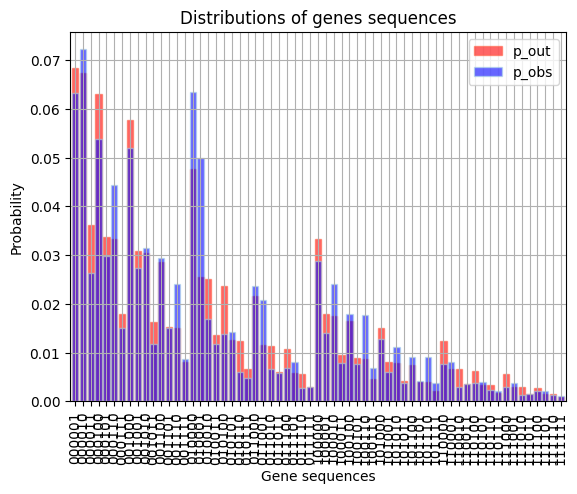

[CHECKPOINT] iteration: 1
[CHECKPOINT] KL loss: 0.046495861782119216
[CHECKPOINT] Constraint loss: 1.1756710721428172
[CHECKPOINT] loss computed: 0.09299172356423843
[CHECKPOINT] iteration: 2
[CHECKPOINT] KL loss: 0.04644515857121301
[CHECKPOINT] Constraint loss: 1.1756710721428179
[CHECKPOINT] loss computed: 0.09289031714242602
[CHECKPOINT] iteration: 3
[CHECKPOINT] KL loss: 0.04639470453223059
[CHECKPOINT] Constraint loss: 1.1756710721428218
[CHECKPOINT] loss computed: 0.09278940906446118
[CHECKPOINT] iteration: 4
[CHECKPOINT] KL loss: 0.046344498790708705
[CHECKPOINT] Constraint loss: 1.175671072142832
[CHECKPOINT] loss computed: 0.09268899758141741
[CHECKPOINT] iteration: 5
[CHECKPOINT] KL loss: 0.04629454048054461
[CHECKPOINT] Constraint loss: 1.1756710721428536
[CHECKPOINT] loss computed: 0.09258908096108923
[CHECKPOINT] iteration: 6
[CHECKPOINT] KL loss: 0.046244828743931155
[CHECKPOINT] Constraint loss: 1.1756710721428931
[CHECKPOINT] loss computed: 0.09248965748786231
[CHECKPO

KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from qiskit_aer import AerSimulator
from qiskit import  transpile,QuantumCircuit
from qiskit.visualization import plot_histogram

from qiskit.quantum_info import Statevector  
from qiskit.visualization import plot_bloch_multivector

from utils import Laplace_smoothing, binary_reshuffling_indeces, binary_labels, big_to_little_endian_vector_state
from debugger_module import *
from quantum_circuit import quantum_circuit_GRN
from loss import loss_function, gradient_loss
from visualization import plot_obs_vs_out_distr

debug = False


######################################################################################
### LOADING THE OBSERVED DATA

p_obs_smooth = pd.read_csv('../p_obs_smoothed.csv',  sep='\t', dtype={0: str, 1: float}, header=None,)
checkpoint(f"p_obs loaded", debug = debug)

#converting single column dataframe into a series
p_obs_smooth = pd.Series(p_obs_smooth[1].values, index=p_obs_smooth[0].values)

#ordering the indices-sequences in ascending order as binary numbers
p_obs_smooth = binary_reshuffling_indeces(p_obs_smooth)
checkpoint(f"p_obs reshuffled", debug = debug)

######################################################################################
### Initial parameters setting

# Reading the stored result for the activation ratio of each gene
act_ratios_df = pd.read_csv('../act_ratios.csv', header=None) 

# Separating the indices from the values
act_ratios = act_ratios_df[1].values 
genes_names = act_ratios_df[0].values
checkpoint(f"genes considered: {genes_names}\nactivation ratios: {act_ratios}", debug = True)

# Initial theta matrix: 0 for all the off-diagonal elements
diagonal_theta = 2*np.arcsin(act_ratios**0.5)
theta_in = np.diag(diagonal_theta) 
checkpoint(f"theta_in loaded, with shape {theta_in.shape}", debug = debug)


#############################################################################################
### OPTIMIZATION PROCESS: FINDING THE BEST THETA

# Setting algorithm's parameters
iterations = 1087 # Number of iterations (AS PAPER)
#iterations = 1 # Number of iterations (DA OSSERVAZIONI DEL PLOT: dopo questo valore torna a crescere)
learn_rate = 0.05 # Learning rate (AS PAPER)
loss_treshold = 0.0064 # AS PAPER
nr_qubits = theta_in.shape[0] # One qubit per gene

n_plots = 5 # number of times the distribution is displayed along the execution

n_cells = 24828 #From observed data

# intial value for the matrix of parameters
theta = theta_in

# Creating an empty dataframe to store the entries of the matrix theta and the loss at each iteration
rows, cols = nr_qubits, nr_qubits 
column_names = [f"θ_{i},{j}" for i in range(rows) for j in range(cols)]
column_names.append('loss')
df = pd.DataFrame(columns=column_names)

for iter in range(iterations): #for each iteration of the algorithm
    
    checkpoint(f"iteration: {iter}", debug=True)
    start_time = time.time() # recording initial time

    #############################################
    ### BUILDING QUANTUM CIRCUIT AND OUTPUT STATE
    ###

    # Computing the matrix associated with the quantum circuit 
    qc_opt = quantum_circuit_GRN(theta)
    checkpoint(f"Quantum circuit built (shape operator {qc_opt.shape})", debug = debug)

    # Computing the initial state, with all qubits initialized to state |0>
    # Oss. little endian and big endian representations for this state have the same representation
    psi_q0 = np.array([1,0], dtype=complex) #state |0>
    psi_in = psi_q0
    for ii in range(nr_qubits-1): # tensorizing the state |0> for each qubit
        psi_in = np.kron(psi_in, [1,0])
    checkpoint(f"Initial state computed (shape {psi_in.shape})", debug = debug)

    
    # Computing output state from the circuit
    psi_out = np.dot(qc_opt, psi_in) #big-endian ordered (see test 2)
    checkpoint(f"Output state computed (shape {psi_out.shape})", debug = debug)
    
    psi_out = big_to_little_endian_vector_state(psi_out)
    checkpoint(f"Output state reordered as little endian", debug = debug)
    
    # Check if psi_out is real, otherwise the formula to compute the gradiend used next is not valid
    if not np.all(np.isreal(psi_out)):
        raise ValueError("The output state of the quantum circuit is not real. The gradient cannot be computed.")


    #############################################
    #### OUTPUT PROBABILITY DISTRIBUTION
    #### Computed from the theoretical output state as the absolute value of its entries
    ####

    # Computing the probability distribution associated to the output state
    p_out = np.abs(psi_out)**2
    checkpoint(f"Output probabilities computed (shape {p_out.shape})", debug = debug)

    # Associating to the probabilities the binary strings representing the state of the system
    # I do this considering that the vector is now represented in little-endian representation 
    # So if the vector is [c_0,c_1,c_2, .. , c_N]
    # c_0 represents state |00....0> 
    # c_1 represents state |00...01> 
    # c_2 represents state |00..010> 
    # c_N represents state |11....1>
    # Function bynary labels covert integers to binary strings so with that you are okay 
    p_out = pd.Series(p_out, index=binary_labels(p_out.shape[0], big_endian=False))  
    checkpoint(f"Labels associated with the distribution, following little-endian ordering", debug = debug)

    # removing entry associated with state in which each qubit is |0>: it represent the situation
    # in which each gene is inactivated, and it is not interesting for this study
    p_out.pop('000000') 
    checkpoint(f"Popped out the non-relevant entries associated to 000000 label, now the entries are {p_out.shape[0]}", debug = debug)
    
    # Renormazlizing
    p_out = p_out / p_out.sum()
    checkpoint(f"P_out renormalized: sum is {p_out.sum()}", debug = debug)

    # Laplace smoothing on p_out
    # CONTROLLA, NON SONO PER NIENTE SICURO DI USARE PER N TRIALS IL NUMERO DI CELLULE
    p_out_smooth = Laplace_smoothing(distribution=p_out, N_trials=n_cells, N_classes=p_out.shape[0])
    checkpoint(f"Smoothing of p_out computed (check normalization: {p_out_smooth.sum()})", debug = debug)
    # p_out_smooth = binary_reshuffling_indeces(p_out_smooth)
    # checkpoint(f"p_out_smooth reordered ", debug = debug)

    ###
    ### LOSS FUNCTION
    ###

    # Check that p_obs_smooth and p_out_smooth have the same dimension and same labels
    if not p_out_smooth.index.equals(p_obs_smooth.index): # both the values and the order of the indices
        raise ValueError(f"p_out_smooth and p_obs_smooth should have the same indices!")
    else:
        checkpoint(f"Both the distributions have the same labels", debug=debug)
        
    loss, rescale_factor = loss_function(p_obs_smooth, p_out_smooth, theta) 
    checkpoint(f"loss computed: {loss}", debug=True)
   
    if loss < loss_treshold:
        break
     
    ###
    ### GRADIENT LOSS 
    ###   
    loss_gradient = gradient_loss(sequences=p_out_smooth.index, theta=theta, psi_in=psi_in, psi_out=psi_out, p_out=p_out_smooth, p_obs=p_obs_smooth, rescale_factor=rescale_factor, debug=debug)
    checkpoint(f"gradient computed: {loss_gradient.shape}", debug=debug)
    
    ###
    ### UPDATING THETA
    ###   
    theta = theta - learn_rate * ( loss_gradient + loss_gradient.T ) / 2
    checkpoint("theta updated", debug=debug)

    theta_values = theta.flatten()
    results = np.append(theta_values, loss)
    df.loc[iter] = results
    stop_time = time.time()

    if iter in np.arange(n_plots)*int(iterations/n_plots):
        plot_obs_vs_out_distr(p_obs_smooth, p_out_smooth)

df.to_csv('..optimization_results.csv')

plt.figure(figsize=(14,6))
plot_obs_vs_out_distr(p_obs_smooth, p_out_smooth, limit=0.01) #final plot


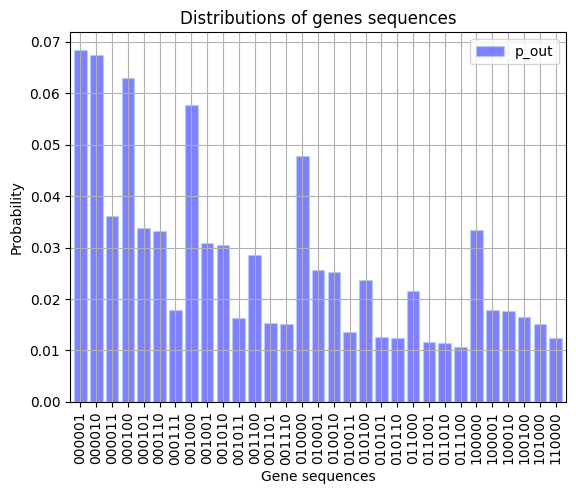

In [2]:
output_distr = p_out_smooth[p_out_smooth>0.01]

output_distr.plot(kind='bar', width=0.8, label='p_out', color='blue', edgecolor='lightblue', alpha=0.5)

plt.xticks(rotation=90)
plt.ylabel('Probability')
plt.xlabel('Gene sequences')
plt.title('Distributions of genes sequences')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
best_theta = theta_in # The best theta found during the optimization process

qc = QuantumCircuit(nr_qubits,nr_qubits) #ALL QUBITS INITIALIZED IN THE STATE |0> OF THE COMPUTATIONAL BASIS


#Defining the "encoding layer" L_enc
for ii in range(nr_qubits):
    qc.ry(best_theta[ii,ii], ii) 
qc.barrier() 

#Defining the correlation layers
for kk in range(nr_qubits):
    #Defining the L_k layer: it uses k-th qubit as control
    for pp in range(nr_qubits):
        if pp != kk:
            qc.cry(best_theta[kk,pp], kk, pp) #Documentation: cry(theta, control, target)
    qc.barrier()

qc.draw("mpl")  
plt.show()

psi_out_qiskit = Statevector(qc).data
tol = tol=1e-6
if np.allclose(psi_out, psi_out_qiskit, atol=tol): 
    print("OK")
else: 
    print("NO bene")

    indices = np.where(~np.isclose(psi_out, psi_out_qiskit, atol=tol))  # Try 1e-5 or even 1e-4
    
    print("Indices where arrays are different:", indices)
    max_diff = np.max(np.abs(psi_out - psi_out_qiskit))
    print(max_diff)
    print()
    print(psi_out[indices])
    print(psi_out_qiskit[indices])


OK


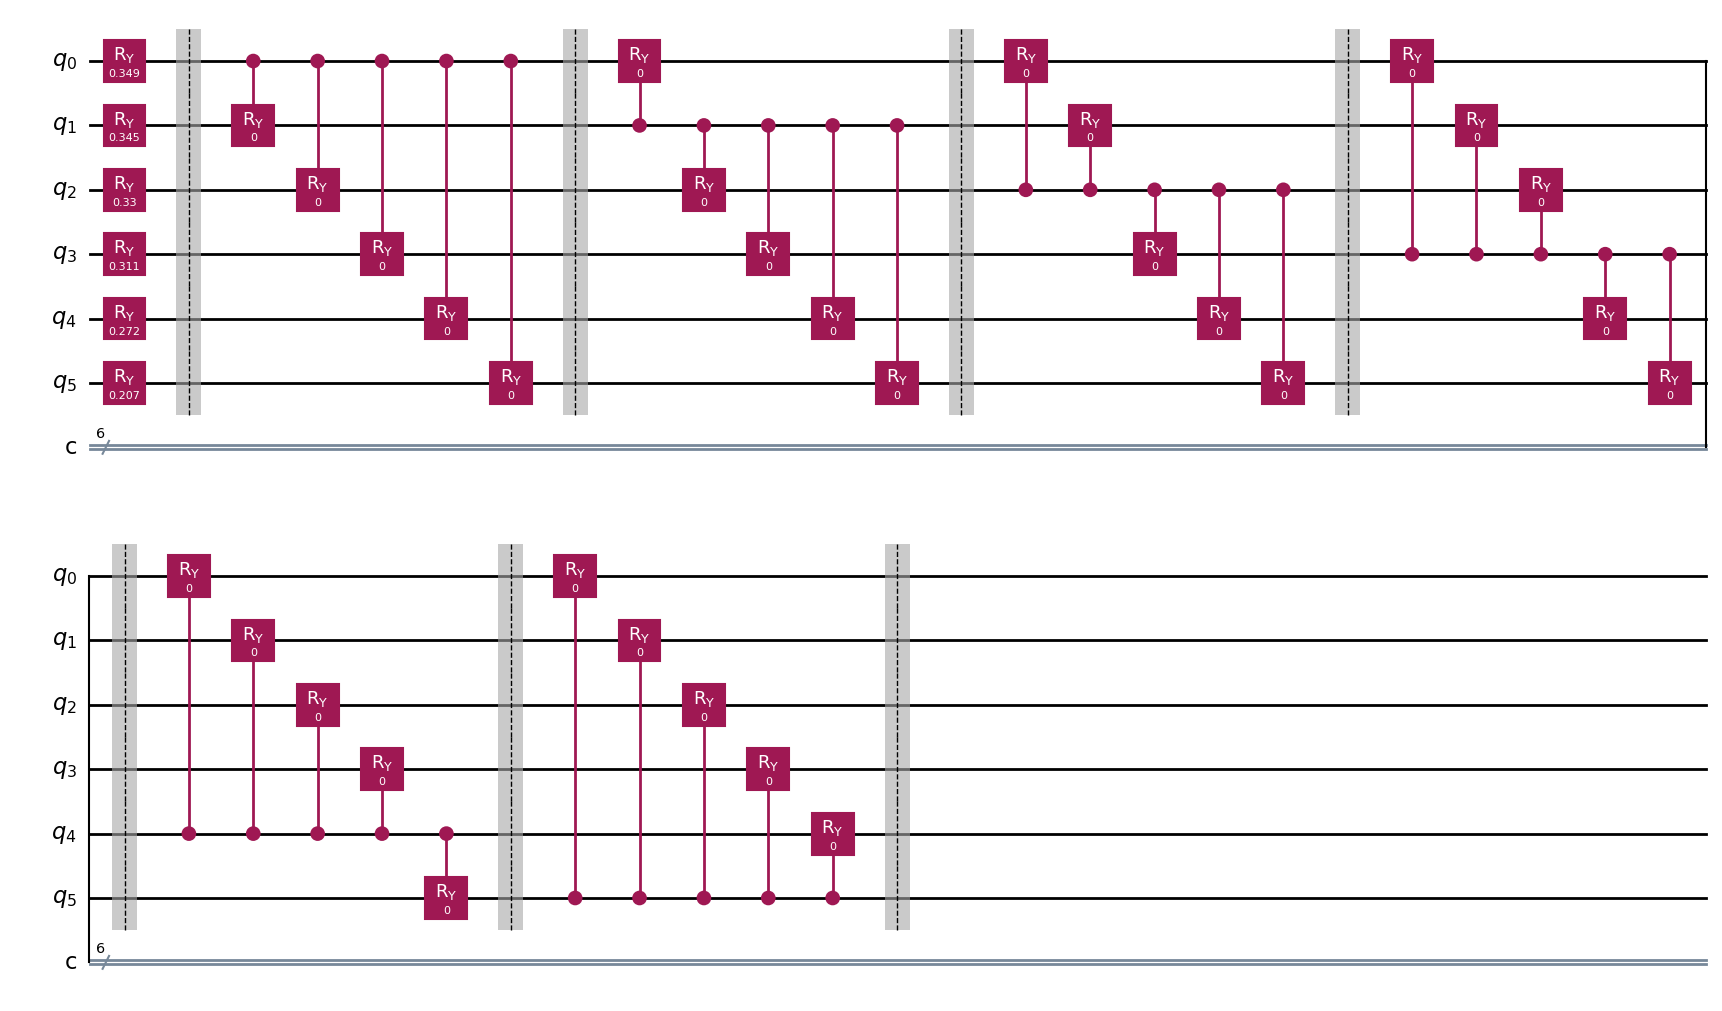

In [27]:

qc.draw("mpl")  


In [30]:
print(theta_in)

[[1.26381363 0.         0.         0.         0.         0.        ]
 [0.         1.25651597 0.         0.         0.         0.        ]
 [0.         0.         1.2248865  0.         0.         0.        ]
 [0.         0.         0.         1.18402743 0.         0.        ]
 [0.         0.         0.         0.         1.09757357 0.        ]
 [0.         0.         0.         0.         0.         0.94459032]]
